In [48]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [49]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dir = "../data/train"  # path to the train folder
validation_dir = "../data/validation"  # path to the validation folder
test_dir = "../data/test"  # path to test folder

train_data = datasets.ImageFolder(root=train_dir, transform=transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=transform)

test_data = datasets.ImageFolder(root=test_dir, transform=transform)

print(
    f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}\n\nTest data:\n{test_data}"
)

data_loaders = {
    "train": DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2),
    "validation": DataLoader(
        validation_data, batch_size=4, shuffle=True, num_workers=2
    ),
}

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 495
    Root location: ../data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 494
    Root location: ../data/test
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5,

In [50]:
class SimpleCNN3(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 22 * 22, 256)
        self.act4 = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = self.pool3(self.act3(self.bn3(self.conv3(out))))
        out = out.view(out.size(0), -1)
        out = self.act4(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

model = SimpleCNN3().to(device)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss, correct = 0, 0
    size = len(dataloader.dataset)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    
    return train_loss / len(dataloader), accuracy

def validate(dataloader, model, loss_fn):
    model.eval()
    validation_loss, correct = 0, 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return validation_loss / len(dataloader), accuracy

In [52]:
# Loss funciton, optimizer and epochs
loss_fn = nn.CrossEntropyLoss()
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
epochs = 1

In [53]:
results = {"lr": [], "train_acc": [], "validation_acc": [], "train_loss": [],"validation_loss": []}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = SimpleCNN3().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_accuracies = []
    validation_accuracies = []
    train_losses = []
    validation_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train(data_loaders["train"], model, loss_fn, optimizer)
        val_loss, val_acc = validate(data_loaders["validation"], model, loss_fn)

        train_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)
        train_losses.append(train_loss)
        validation_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    results["lr"].append(lr)
    results["train_acc"].append(train_accuracies[-1])
    results["validation_acc"].append(validation_accuracies[-1])
    results["train_loss"].append(train_losses[-1])
    results["validation_loss"].append(validation_losses[-1])
    print(f"Last Train Accuracy for LR={lr}: {train_accuracies[-1]:.2f}%")

Training with learning rate: 0.0001
Epoch 1/1
Train Loss: 0.6073, Validation Loss: 0.5890
Train Accuracy: 69.80%, Validation Accuracy: 69.49%
Last Train Accuracy for LR=0.0001: 69.80%
Training with learning rate: 0.0005
Epoch 1/1
Train Loss: 0.6118, Validation Loss: 0.5921
Train Accuracy: 69.45%, Validation Accuracy: 69.49%
Last Train Accuracy for LR=0.0005: 69.45%


In [36]:
import json

with open("./results/learning_rate1.json", "w") as file:
    json.dump(results, file, indent=4)

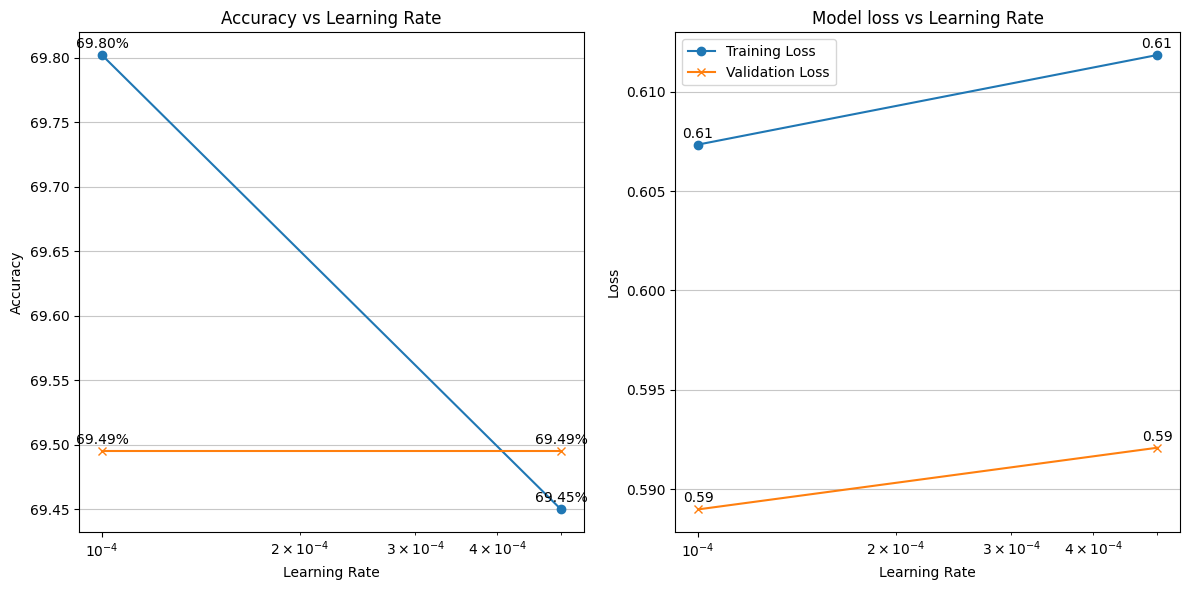

In [55]:
plt.figure(figsize=(12, 6))

# Train accuracy vs Learning rate
plt.subplot(1, 2, 1)
plt.plot(results["lr"], results["train_acc"], label="Training Accuracy", marker="o")
plt.plot(
    results["lr"], results["validation_acc"], label="Validation Accuracy", marker="x"
)

# Dodanie wartości na punktach
for lr, acc in zip(results["lr"], results["train_acc"]):
    plt.annotate(
        f"{acc:.2f}%", (lr, acc), textcoords="offset points", xytext=(0, 5), ha="center"
    )
for lr, acc in zip(results["lr"], results["validation_acc"]):
    plt.annotate(
        f"{acc:.2f}%", (lr, acc), textcoords="offset points", xytext=(0, 5), ha="center"
    )

plt.title("Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.xscale("log")

# Loss vs Learning rate
plt.subplot(1, 2, 2)
plt.plot(results["lr"], results["train_loss"], label="Training Loss", marker="o")
plt.plot(results["lr"], results["validation_loss"], label="Validation Loss", marker="x")

# Dodanie wartości na punktach
for lr, loss in zip(results["lr"], results["train_loss"]):
    plt.annotate(
        f"{loss:.2f}",
        (lr, loss),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
for lr, loss in zip(results["lr"], results["validation_loss"]):
    plt.annotate(
        f"{loss:.2f}",
        (lr, loss),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )

plt.title("Model loss vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.xscale("log")
plt.legend()

plt.tight_layout()
plt.show()